# Prediction with CNN using 2D lat/lon data

**Author:** Eli Holmes (NOAA), Yifei Hang (UW Varanasi intern 2024), Jiarui Yu (UW Varanasi intern 2023)


This notebook shows how to train a basic Convolutional Neural Network on 2D data (a lat/lon grid of environmental variables) to predict a different 2D data layer. Although you can run this tutorial on CPU, it will be much faster on GPU. We used the image `quay.io/pangeo/ml-notebook:2025.05.22` for running the notebook. See the "Simple CNN example" tab for how to select the JupyterHub image.

This will be a toy example of predicting chlorophyll-a using SST and salinity. This won't work very well but we will learn the process.

## Load the libraries that we need

**TensorFlow** is a popular open-source Python library for building and training machine learning models, especially deep learning models like neural networks, including convolutional neural networks.

**Keras** is a high-level interface that runs on top of TensorFlow. It makes it easier to build models by providing simple building blocks like layers, optimizers, and training loops.

In this notebook, we’ll use Keras to:
- Build our Convolutional Neural Network (CNN)
- Train it to predict ocean chlorophyll from two predictors: SST and salinity
- Monitor training performance and make predictions

We use the Keras `Conv2D` module since we are training on lat/lon 2D spatial data.

In [3]:
# --- Core data handling libraries ---
import xarray as xr       # for working with labeled multi-dimensional arrays
import numpy as np        # for numerical operations on arrays
import dask.array as da   # for lazy, parallel array operations (used in xarray backends)

# --- Plotting ---
import matplotlib.pyplot as plt  # for creating plots

# --- TensorFlow setup ---
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # suppress TensorFlow log spam (0=all, 3=only errors)

import tensorflow as tf  # main deep learning framework

# --- Keras (part of TensorFlow): building and training neural networks ---
from keras.models import Sequential          # lets us stack layers in a simple linear model
from keras.layers import Conv2D              # 2D convolution layer — finds spatial patterns in image-like data
from keras.layers import BatchNormalization  # stabilizes and speeds up training by normalizing activations
from keras.layers import Dropout             # randomly "drops" neurons during training to reduce overfitting
from keras.callbacks import EarlyStopping    # stops training early if validation loss doesn't improve

2025-06-07 00:32:12.069179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-07 00:32:12.086872: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-07 00:32:12.092340: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## See what machine we are on

In [4]:
# list all the physical devices
physical_devices = tf.config.list_physical_devices()
print("All Physical Devices:", physical_devices)

# list all the available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Print infomation for available GPU if there exists any
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print("GPU Details:", details)
else:
    print("No GPU available")

All Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Details: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


## Load and set up our input data

For this toy example, we need to pick a response variable (Chlorophyll) without many missing values. We will deal with missing values in our response variable in Part II. The `CHL_cmes-gapfree` variable is the *mostly* gapfree GlobColour CHL product. We will use that. *Mostly* gapfree because the nature of their algorithm means that is some days of the year there will still be NaNs. If a pixel has never been cloud-free on a given day in their training set (like 10-15 years) then that pixel will be NaN. But the `CHL_cmes-gapfree` product is good enough for what we are doing in Part I. We just don't want to use ``CHL_cmes-level3` because that has all the cloud NaN (i.e. is not gap filled) and has too many NaNs.

In [5]:
# read in the Zarr file; a 3D (time, lat, lon) cube for a bunch of variables in the Indian Ocean
zarr_ds = xr.open_zarr("~/shared/mind_the_chl_gap/IO.zarr")
zarr_ds

<xarray.Dataset> Size: 66GB
Dimensions:                       (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat                           (lat) float32 708B 32.0 31.75 ... -11.75 -12.0
  * lon                           (lon) float32 964B 42.0 42.25 ... 101.8 102.0
  * time                          (time) datetime64[ns] 129kB 1979-01-01 ... ...
Data variables: (12/27)
    CHL                           (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes-cloud                (time, lat, lon) uint8 686MB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes-gapfree              (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes-land                 (lat, lon) uint8 43kB dask.array<chunksize=(177, 241), meta=np.ndarray>
    CHL_cmes-level3               (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes_flags-gapfree        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    ...                            ...
    ug_curr                       (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_curr                        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_wind                        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    vg_curr                       (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_dir                      (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_speed                    (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

In [6]:
# slice to a lat/lon segment
zarr_sliced = zarr_ds.sel(lat=slice(35, -5), lon=slice(45,90))

# This is what we are trying to predict: chlorophyll. We use an gap-filled data set
CHL_var = "CHL_cmes-gapfree"

# remove early years with no CHL data; these will be all NaN
all_nan_CHL = np.isnan(zarr_sliced[CHL_var]).all(dim=["lon", "lat"]).compute()  
zarr_CHL = zarr_sliced.sel(time=(all_nan_CHL == False))  # select samples with CHL not NaN

# Get one year of data to work with, so it goes fast
zarr_CHL = zarr_CHL.sortby('time')
zarr_CHL = zarr_CHL.sel(time=slice('2020-01-01', '2020-12-31'))

# Fix a chunk problem
chunk_dict = dict(zip(zarr_CHL["sst"].dims, zarr_CHL["sst"].chunks))
zarr_CHL["so"] = zarr_CHL["so"].chunk(chunk_dict)

# Select just the vars we need
zarr_CHL = zarr_CHL[["sst", "so", CHL_var, "CHL_cmes-land"]]

# Fix the land mask to True/False; ocean = True
zarr_CHL["CHL_cmes-land"] = zarr_CHL["CHL_cmes-land"] == 0 
invalid_ocean = np.isnan(zarr_CHL["sst"]).all(dim="time") # Mark where SST is always missing (likely lakes)
# Update land_mask: set to False (i.e. land/lake) where SST is always NaN
zarr_CHL["CHL_cmes-land"] = zarr_CHL["CHL_cmes-land"].where(~invalid_ocean, other=False)

# Rename our CHL_var to CHL
zarr_CHL = zarr_CHL.rename({CHL_var: "CHL", "CHL_cmes-land": "ocean_mask"})

zarr_CHL

<xarray.Dataset> Size: 118MB
Dimensions:     (time: 366, lat: 149, lon: 181)
Coordinates:
  * lat         (lat) float32 596B 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon         (lon) float32 724B 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time        (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    sst         (time, lat, lon) float32 39MB dask.array<chunksize=(7, 149, 181), meta=np.ndarray>
    so          (time, lat, lon) float32 39MB dask.array<chunksize=(7, 149, 181), meta=np.ndarray>
    CHL         (time, lat, lon) float32 39MB dask.array<chunksize=(7, 149, 181), meta=np.ndarray>
    ocean_mask  (lat, lon) bool 27kB dask.array<chunksize=(149, 181), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

## Check the NaNs

First let's look at our ocean mask. 1 for land and 0 for water/ocean and no big lakes! Great.

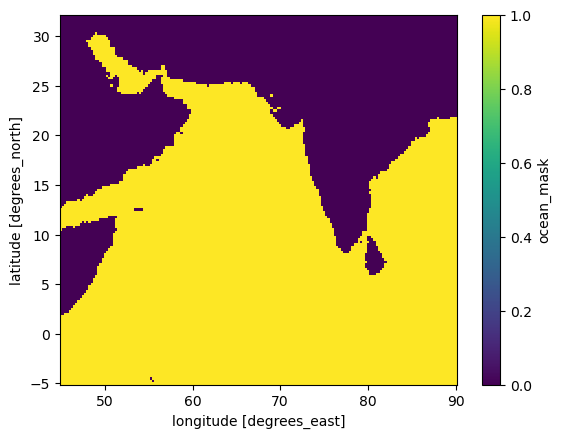

In [5]:
zarr_CHL["ocean_mask"].plot();

Check that we don't have too many NaNs.

In [7]:
# Broadcast to 3D: (time, lat, lon)
mask_xr = zarr_CHL["ocean_mask"]
mask_3d = mask_xr.broadcast_like(zarr_CHL["sst"])

# Count NaNs over ocean only
for var in ["sst", "so", "CHL"]:
    var_data = zarr_CHL[var]
    ocean_nan = np.isnan(var_data) & mask_3d
    max_nan = ocean_nan.sum(dim=["lat", "lon"]).max().compute()
    print(f"{var}: max ocean NaNs per time step = {int(max_nan)}")

sst: max ocean NaNs per time step = 0
so: max ocean NaNs per time step = 79
CHL: max ocean NaNs per time step = 1602


### Get rid of days where our response has too many NaNs

A rule of thumb is not to have more than 5-10% of NaNs in your response variable, otherwise the CNNs will be training on too much missingness. For us, 5% is about 800 missing pixels.

In [8]:
0.05 * zarr_CHL["ocean_mask"].sum().values

832.0500000000001

In [9]:
# Create 3D mask (True = valid ocean pixel)
mask_3d = zarr_CHL["ocean_mask"].broadcast_like(zarr_CHL["CHL"])

# Count missing CHL values over ocean for each time step
chl_nan = np.isnan(zarr_CHL["CHL"]) & mask_3d
chl_nan_count = chl_nan.sum(dim=["lat", "lon"])

# Set threshold: exclude days with too much missing CHL
valid_times = chl_nan_count < 832

# Apply time filtering
zarr_CHL = zarr_CHL.sel(time=valid_times)
print(f"Remaining days after CHL filtering: {zarr_CHL.sizes['time']}")

Remaining days after CHL filtering: 321


## Visualize the data

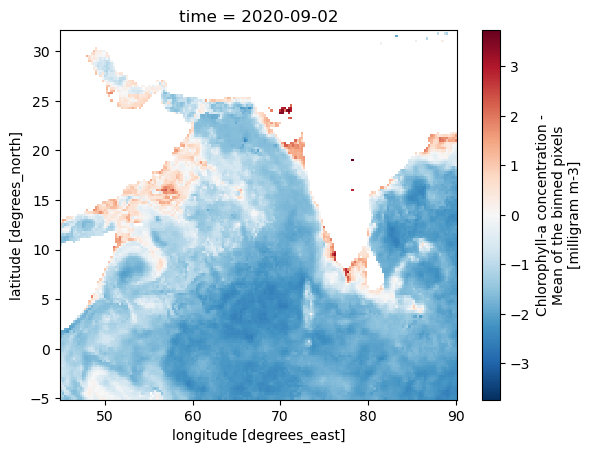

In [10]:
date_to_predict = '2020-09-02'
# log scale
np.log(zarr_CHL.CHL.sel(time=date_to_predict)).plot(y='lat', x='lon');

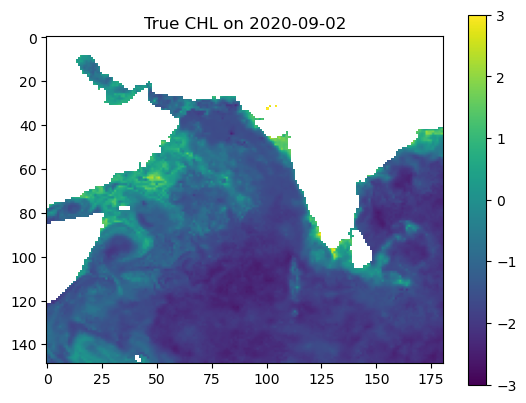

In [10]:
output = np.log(zarr_CHL.CHL.sel(time=date_to_predict))
plt.imshow(output, vmin=-3, vmax=3)
plt.colorbar()
plt.title(f'True CHL on {date_to_predict}')
plt.show()


## Process the data

We need to split into our training and testing data. I will create some functions to help with this.

**Note on Missing Values and Masking (Part 1)**

TensorFlow cannot handle any NaNs. In this first part of the tutorial, we are **not using a land or CHL mask**. Instead, we keep it simple by:

- Replacing all missing values (NaNs) with **0**
- Using the raw `CHL` data as-is, only filtering out days with too many NaNs beforehand
- Training the model to learn from the data wherever it exists. It is going to spend extra time learning "CHL" on land where CHL, SST and salinity are all set to 0.

In **Part 2**, we will show how to handle missing data more carefully using a mask during training.

In [26]:
import numpy as np
import dask.array as da

def log_label(data, label):
    """
    Take the log of the label variable (e.g., CHL) and return a modified copy of the dataset.
    """
    data_logged = data.copy()
    data_logged[label] = np.log(data[label]).copy()
    return data_logged

def preprocess_data(data, features, label):
    """
    Prepare input and label arrays for training:
    - Take log of label
    - Replace NaNs in all variables with 0
    - Stack features and label into a single Dask array: (n_vars, time, lat, lon)
    """
    # Apply log transform to label
    data_logged = log_label(data, label)
    
    # Stack all variables (features + label), replacing NaNs with 0
    sel_data_list = []
    for var in features + [label]:
        filled = da.where(da.isnan(data_logged[var]), 0.0, data_logged[var])
        sel_data_list.append(filled)
    
    # Create a stacked array with shape: (n_vars, time, lat, lon)
    return da.stack(sel_data_list)

def time_series_split(data, split_ratio):
    X = data[:-1]
    y = data[-1]
    
    X = np.moveaxis(X, 0, -1)

    total_length = X.shape[0]
    
    train_end = int(total_length * split_ratio[0])
    val_end = int(total_length * (split_ratio[0] + split_ratio[1]))

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end: val_end], y[train_end: val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    return (X, y, X_train, y_train,
            X_val, y_val,
            X_test, y_test)


Here we create our training and test data with 2 variables using only 2020. 70% data for training, 20% for validation and 10% for testing.

In [27]:
 # Curr Features: Sea Surface Temp (K), Sea Salinity Concentration (m**-3 or PSL). [Excluding Topography/Bathymetry (m)]
features = ['sst', 'so'] 
label = 'CHL'  # chlorophyll-a concentration (mg/m**3) [Not taking uncertainty into consideration for now]
#label = 'CHL_cmes-level3'  # chlorophyll-a concentration (mg/m**3) [Not taking uncertainty into consideration for now]
model_data = preprocess_data(zarr_CHL, features, label)

split_ratio = [.7, .2, .1]
X, y, X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(model_data, split_ratio)

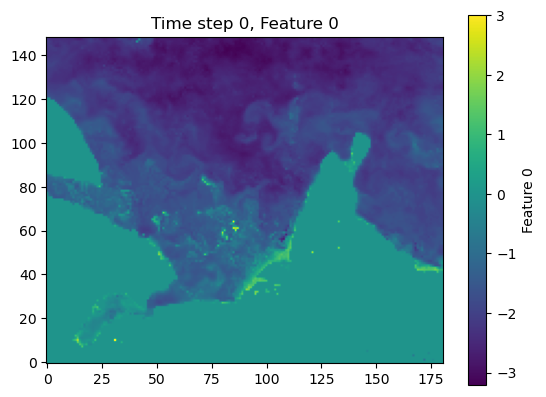

In [37]:
import matplotlib.pyplot as plt

# Example: plot the first time step (index 0) and the first feature (index 0)
slice_to_plot = y[10, :, :].compute()

plt.imshow(slice_to_plot, origin='lower', vmax=3)  # Adjust origin as needed
plt.colorbar(label="Feature 0")
plt.title("Time step 0, Feature 0")
plt.show()

In [40]:
import numpy as np

np.save("X.npy", X.compute())
np.save("y.npy", y.compute())
np.save("X_train.npy", X_train.compute())
np.save("y_train.npy", y_train.compute())


## Create the CNN model

In [17]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, BatchNormalization, Dropout

def create_model_CNN(input_shape):
    """
    Create a simple 3-layer CNN model for gridded ocean data.

    Parameters
    ----------
    input_shape : tuple
        The shape of each sample, e.g., (149, 181, 2)

    Returns
    -------
    model : keras.Model
        CNN model to predict CHL from SST and salinity
    """
    model = Sequential()

    # Input layer defines the input dimensions for the CNN
    model.add(Input(shape=input_shape))

    # Layer 1 — learns fine-scale 3x3 spatial features
    # Let the model learn 64 different patterns (filters) in the data at this layer.
    # activation relu is non-linearity
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Layer 2 — expands context to 5x5; combines fine features into larger structures
    # Reduce the number of patterns (filters) so we gradually reduce model complexity
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Layer 3 — has access to ~7x7 neighborhood; outputs CHL prediction per pixel
    # Combines all the previous layer’s features into a CHL estimate at each pixel
    # 1 response (chl) — hence, 1 prediction pixel = filter
    # linear since predicting a real continuous variable (log CHL)
    model.add(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='linear'))

    return model

### Let's build the model

We build a simple 3-layer CNN model. Each layer preserves the (lat, lon) shape and learns filters to extract spatial patterns. The model has ~20,000 trainable parameters, which we can see from `model.summary()`. This is small compared to huge modern CNNs (millions of parameters).

In [18]:
# Get shape of one input sample: (lat, lon, n_features)
input_shape = X_train.shape[1:]

# Create the model using the correct input shape
model = create_model_CNN(input_shape)

# Check the model summary
# model.summary()

## Let's train the model

In [19]:
# Compile the model with Adam optimizer and mean absolute error (MAE) as both loss and evaluation metric
model.compile(
    optimizer='adam',    # Efficient and widely used optimizer
    loss='mae',          # Mean Absolute Error: good for continuous data like CHL
    metrics=['mae']      # Also track MAE during training/validation
)

# Set up early stopping to prevent overfitting
early_stop = EarlyStopping(
    patience=10,              # Stop if validation loss doesn't improve for 10 epochs
    restore_best_weights=True  # Revert to the model weights from the best epoch
)

# Create a TensorFlow dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024)  # Shuffle the data (helps generalization)
train_dataset = train_dataset.batch(8)                   # Batch size = 8

# Create a TensorFlow dataset for validation (no shuffle)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(8)

# Train the model
history = model.fit(
    train_dataset,
    epochs=50,                    # Maximum number of training epochs
    validation_data=val_dataset, # Use validation data during training
    callbacks=[early_stop]       # Stop early if no improvement
)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 1.3669 - mae: 1.3669 - val_loss: 1.9652 - val_mae: 1.9652
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9603 - mae: 0.9603 - val_loss: 1.2158 - val_mae: 1.2158
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6647 - mae: 0.6647 - val_loss: 0.9992 - val_mae: 0.9992
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5383 - mae: 0.5383 - val_loss: 0.4109 - val_mae: 0.4109
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4814 - mae: 0.4814 - val_loss: 0.3713 - val_mae: 0.3713
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4455 - mae: 0.4455 - val_loss: 0.6150 - val_mae: 0.6150
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4034 - mae: 0.4034 - val_loss: 0.4928 - val_mae: 0.4928
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3870 - mae: 0.3870 - val_loss: 0.6998 - val_mae: 0.6998
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.381

## Plot training & validation loss values

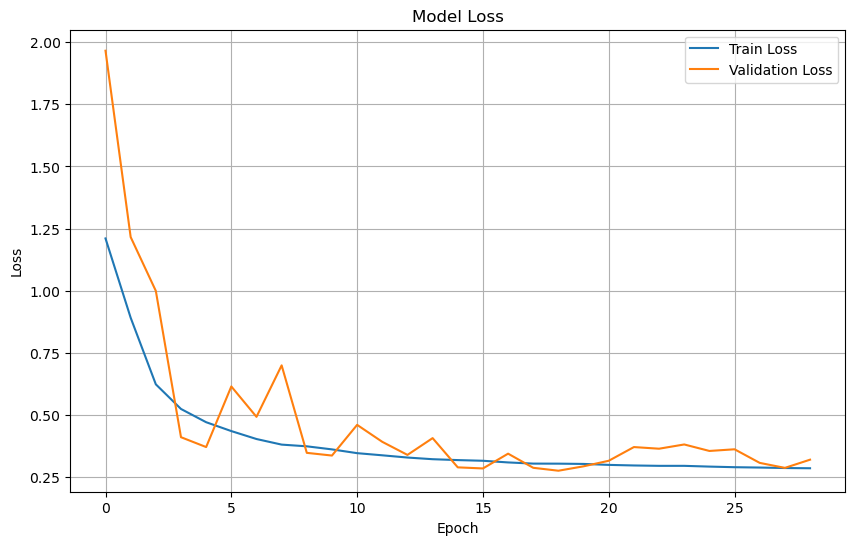

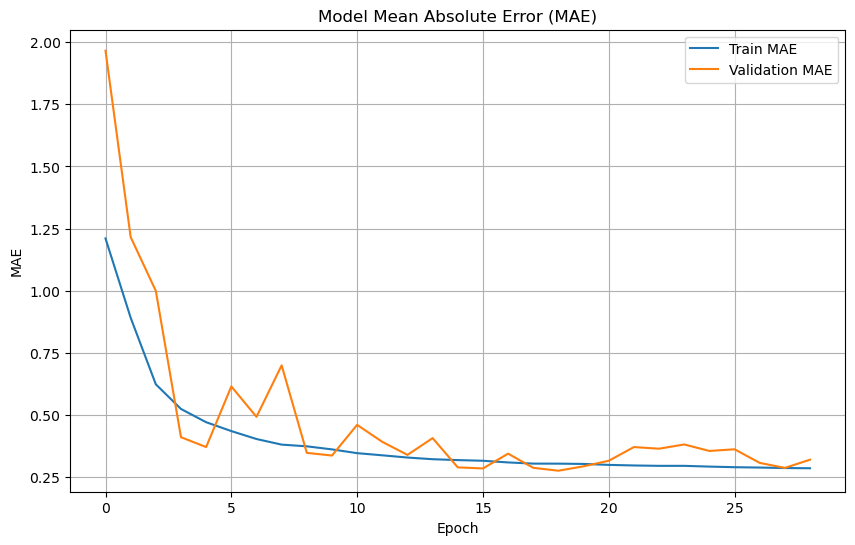

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Prepare test dataset

In [19]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(4)

# Evaluate the model on the test dataset
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1951 - mae: 0.1951
Test Loss: 0.19065508246421814
Test MAE: 0.19065508246421814


## Make some maps of our predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


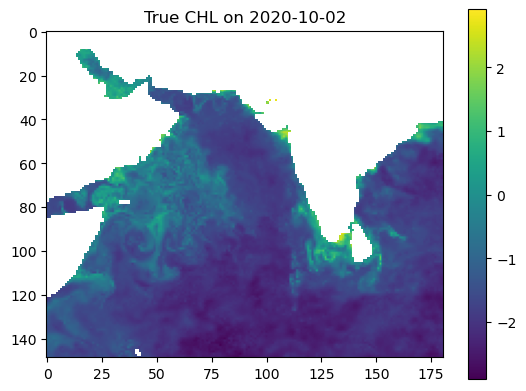

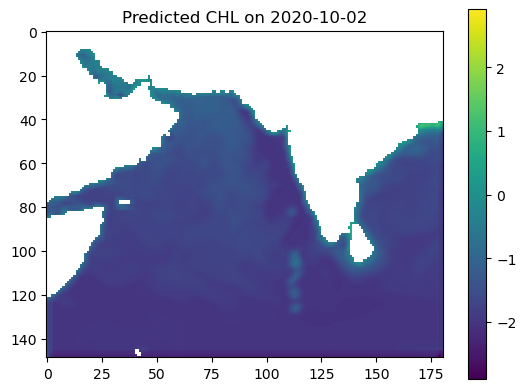

In [21]:
date_to_predict = '2020-10-02'
date_index = (np.datetime64(date_to_predict) - np.datetime64('2020-01-01')).item().days
input = np.moveaxis(model_data[:-1], 0, -1)[date_index]
input = np.array(input)
predicted_output = model.predict(input[np.newaxis, ...])[0]
predicted_output = predicted_output[:,:,0]

# set land to NaN
land_mask = ~zarr_CHL["ocean_mask"].values
predicted_output[land_mask] = np.nan

true_output = np.log(zarr_CHL['CHL'].sel(time=date_to_predict))

vmax = np.nanmax((true_output, predicted_output))
vmin = np.nanmin((true_output, predicted_output))

plt.imshow(true_output, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f'True CHL on {date_to_predict}')
plt.show()

plt.imshow(predicted_output, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f'Predicted CHL on {date_to_predict}')
plt.show()



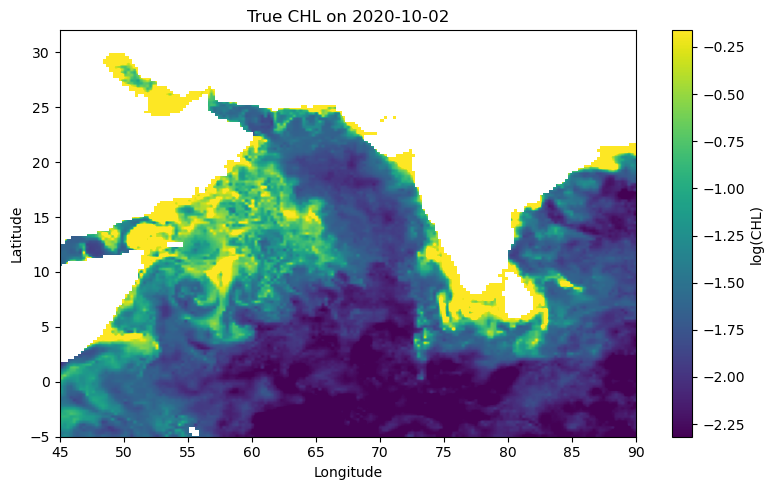

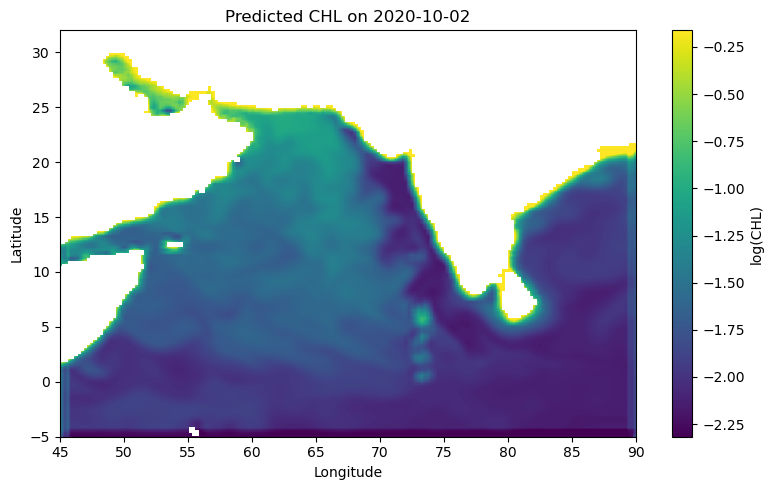

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Get lat/lon values
lat = zarr_CHL.lat.values
lon = zarr_CHL.lon.values

# Flip if lat is descending
if lat[0] > lat[-1]:
    true_output = np.flipud(true_output)
    predicted_output = np.flipud(predicted_output)
    lat = lat[::-1]

# Define plot extent
extent = [lon.min(), lon.max(), lat.min(), lat.max()]

# Contrast enhancement
vmin = np.nanpercentile([true_output, predicted_output], 5)
vmax = np.nanpercentile([true_output, predicted_output], 95)

# True CHL
plt.figure(figsize=(8, 5))
plt.imshow(true_output, vmin=vmin, vmax=vmax, cmap='viridis',
           origin='lower', extent=extent, aspect='auto')
plt.colorbar(label='log(CHL)')
plt.title(f'True CHL on {date_to_predict}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

# Predicted CHL
plt.figure(figsize=(8, 5))
plt.imshow(predicted_output, vmin=vmin, vmax=vmax, cmap='viridis',
           origin='lower', extent=extent, aspect='auto')
plt.colorbar(label='log(CHL)')
plt.title(f'Predicted CHL on {date_to_predict}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


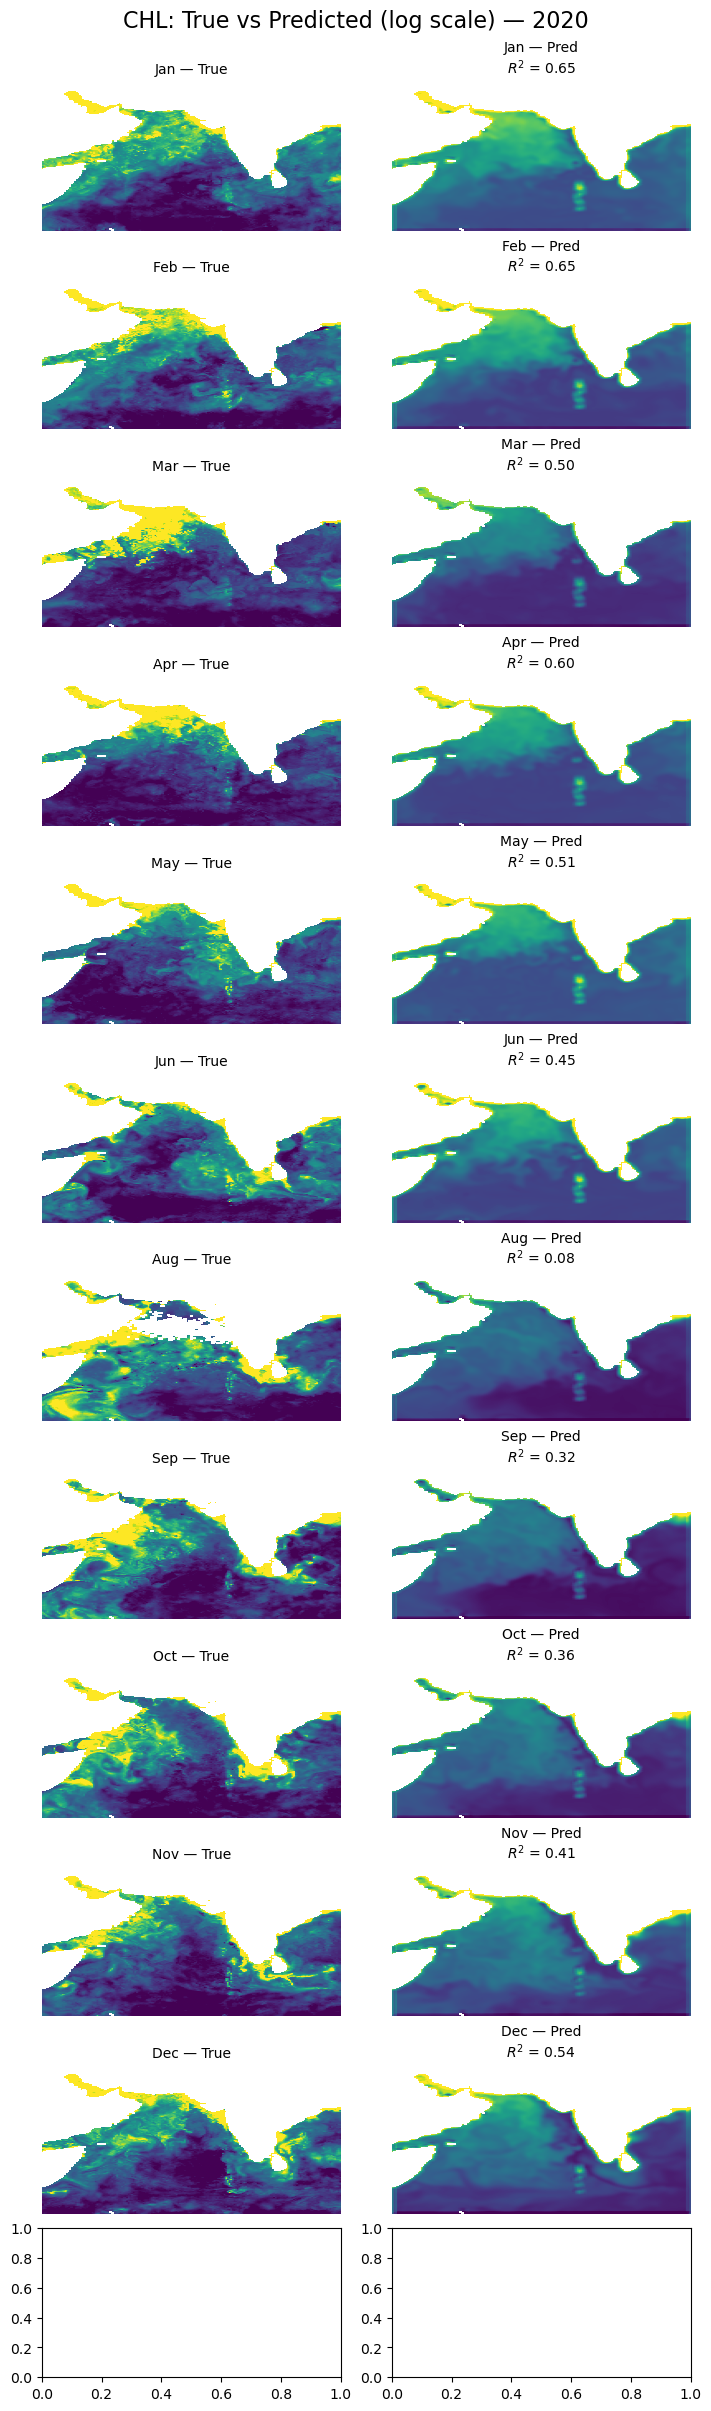

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# Get available time points and group by month
available_dates = pd.to_datetime(zarr_CHL.time.values)
monthly_dates = (
    pd.Series(available_dates)
    .groupby([available_dates.year, available_dates.month])
    .min()
    .sort_values()
)[:12]  # First 12 months

# lat/lon info
lat = zarr_CHL.lat.values
lon = zarr_CHL.lon.values
extent = [lon.min(), lon.max(), lat.min(), lat.max()]
flip_lat = lat[0] > lat[-1]
land_mask = ~zarr_CHL["ocean_mask"].values

# Create figure and axes
fig, axs = plt.subplots(12, 2, figsize=(7, 24), constrained_layout=True)

for i, date in enumerate(monthly_dates):
    # Get time index
    date_index = np.where(available_dates == date)[0][0]

    # True output
    true_output = np.log(zarr_CHL['CHL'].sel(time=date).values)
    if flip_lat:
        true_output = np.flipud(true_output)

    # Prediction
    input = np.moveaxis(model_data[:-1], 0, -1)[date_index].compute()
    predicted_output = model.predict(input[np.newaxis, ...])[0][:, :, 0]
    predicted_output[land_mask] = np.nan
    if flip_lat:
        predicted_output = np.flipud(predicted_output)

    # Shared color scale
    vmin = np.nanpercentile([true_output, predicted_output], 5)
    vmax = np.nanpercentile([true_output, predicted_output], 95)

    # Compute R² (flatten and mask NaNs)
    true_flat = true_output.flatten()
    pred_flat = predicted_output.flatten()
    valid_mask = ~np.isnan(true_flat) & ~np.isnan(pred_flat)
    r2 = r2_score(true_flat[valid_mask], pred_flat[valid_mask])

    # Plot true
    axs[i, 0].imshow(true_output, origin='lower', extent=extent,
                     vmin=vmin, vmax=vmax, cmap='viridis', aspect='auto')
    axs[i, 0].set_title(f"{date.strftime('%b')} — True", fontsize=10)
    axs[i, 0].axis('off')

    # Plot predicted with R²
    axs[i, 1].imshow(predicted_output, origin='lower', extent=extent,
                     vmin=vmin, vmax=vmax, cmap='viridis', aspect='auto')
    axs[i, 1].set_title(f"{date.strftime('%b')} — Pred\n$R^2$ = {r2:.2f}", fontsize=10)
    axs[i, 1].axis('off')

plt.suptitle('CHL: True vs Predicted (log scale) — 2020', fontsize=16)
plt.show()


## Summary

This is a simple CNNs model but it managed to do ok with just 2 variables. But we **have** to deal with the land mask. We will do that in Part 2. In Part 3, we will start doing a more realistic problem: gap-filling cloud-masked level 3 data. Then we will start getting more reasonable predictions and without all the 'smudging'.